In [1]:
from typing import List, Dict, Mapping, Tuple

import chex
import jax
import jax.numpy as jnp
import jax.random as jrand
import flax.linen as nn
from flax.training import train_state  # Useful dataclass to keep train state
import optax
import tensorflow as tf
import pdb
import functools

def println(*args):
  for arg in args:
    print(arg)


In [2]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
DEVICE_COUNT = len(jax.devices())
DEVICE_COUNT

8

In [91]:
BATCH_SIZE = 1024

## Dataset pipline

In [92]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Create a TensorFlow data pipeline for the training set
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(buffer_size=5000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    .as_numpy_iterator())

# Create a TensorFlow data pipeline for the test set.
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    .as_numpy_iterator())

def get_batch(training: bool = True):
  images, labels = (
      next(train_dataset) if training
      else next(test_dataset))

  images, labels = jnp.array(images), jnp.array(labels)
  images = jnp.reshape(images, (BATCH_SIZE, -1)) # flatten the images
  return images, labels

### test get_batch

In [93]:
test_images, test_labels = get_batch()
test_images.shape, test_labels.shape

((1024, 784), (1024, 10))

In [94]:
test_image, test_label = test_images[0], test_labels[0]
test_image.shape

(784,)

## Modeling

In [95]:
class Autoencoder(nn.Module):
    def setup(self):
      self._encoder = nn.Sequential([
        nn.Dense(512),
        nn.relu,
        nn.Dense(256),
        nn.relu,
        nn.Dense(128),
        nn.relu,
        nn.Dense(64) # latent representation
      ])

      self._decoder = nn.Sequential([
          nn.Dense(128),
          nn.relu,
          nn.Dense(256),
          nn.relu,
          nn.Dense(512),
          nn.relu,
          nn.Dense(784), # reconstructed image
      ])
    @nn.compact
    def __call__(self, x, training: bool = False):
        # Encoder
        encoded = self._encoder(x)

        # Decoder
        decoded = self._decoder(encoded)
        return decoded


In [97]:
class TrainState(train_state.TrainState):
  key: jax.random.KeyArray

random_key = jax.random.PRNGKey(99)
random_key, random_subkey = jax.random.split(random_key)

model = Autoencoder()

output, params = model.init_with_output(jrand.PRNGKey(99), test_image, training=False)
params = params["params"]


In [98]:
def model_apply(params, inputs):
  return model.apply({"params": params}, inputs, False)

model_apply_batch = jax.vmap(model_apply, in_axes=(None, 0), out_axes=(0))

def forward_pass(params, state, batch):
  inputs, _ = batch # you are using reconstruction loss, so NOneed of targets.
  reconstructed = state.apply_fn(params, inputs)
  loss = (inputs - reconstructed) ** 2
  loss = loss.mean()
  return loss

def train_step(state, inputs, targets):
  batch = inputs, targets
  grad_fn = jax.value_and_grad(forward_pass, argnums=(0))  # differentiate wrt 0th pos argument.
  loss, grads = grad_fn(state.params, state, batch)

  loss = jax.lax.pmean(loss, axis_name="devices")
  grads = jax.lax.pmean(grads, axis_name="devices")

  state = state.apply_gradients(grads=grads)
  return state, loss

opt = optax.adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model_apply_batch, params=params, tx=opt, key=random_key)

In [99]:
# pmap the train_step.
train_step_pmap = jax.pmap(train_step, in_axes=(0, 0, 0), out_axes=(0), axis_name="devices")

In [100]:
# replicate state
states = jax.device_put_replicated(state, jax.local_devices())

In [101]:
for epoch in range(1000):
  inputs, targets = get_batch()

  # create device dimension for minibatch
  inputs = inputs.reshape((jax.device_count(), -1, inputs.shape[-1]))
  targets = targets.reshape((jax.device_count(), -1, targets.shape[-1]))

  states, loss = train_step_pmap(states, inputs, targets)
  print("loss", loss[0], "epoch", epoch) if epoch%100==0 else None

loss 0.11405046 epoch 0
loss 0.029450849 epoch 100
loss 0.020982612 epoch 200
loss 0.016918516 epoch 300
loss 0.015162249 epoch 400
loss 0.013914181 epoch 500
loss 0.013370213 epoch 600
loss 0.012628719 epoch 700
loss 0.0128231915 epoch 800
loss 0.01179614 epoch 900


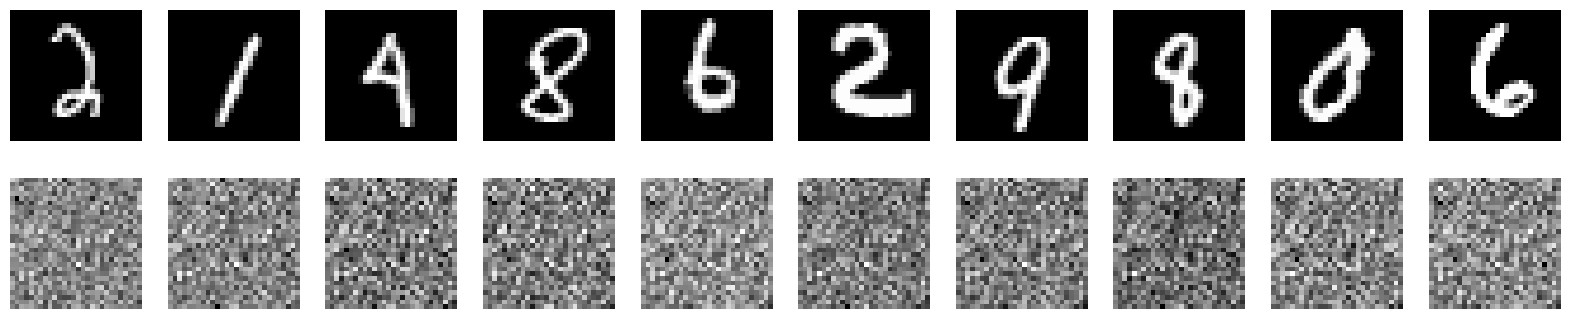

In [102]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, params, batch, n=10):
    inputs, _ = batch
    reconstructed = model_apply_batch(params, inputs)
    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Visualize some reconstructions
plot_reconstructions(model, params, get_batch())
